In [1]:
import math 
import numpy as np 

In [2]:
import sys
# 这将打印出 web 环境中 python 解释器的路径
print(sys.executable)

/home/litao/anaconda3/envs/web/bin/python3


In [164]:
# !conda env list 

In [8]:
from graphviz import Digraph 

In [9]:
# import torch 

In [10]:
# torch.cuda.is_available()

In [11]:
import matplotlib.pyplot as plt 
%matplotlib inline

### 数据维度

In [12]:
x = np.array([[1,2,3], [4,5,6] ]) # 老样子, 几层括号就是几维

In [13]:
type(x)

numpy.ndarray

In [14]:
x.__class__

numpy.ndarray

In [15]:
x.shape

(2, 3)

In [16]:
x.ndim

2

### 开始

In [17]:
def f(x):
    return 3*x**2 - 4*x + 5

In [18]:
f(3)

20

In [19]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

# ys

plt.plot(xs, ys )

In [20]:
h = 0.00001 # 这个应该足够小
x = 3.0
f(x + h), f(x)

(20.0001400003, 20.0)

In [21]:
(f(x + h) - f(x)) / h 

14.00003000000538

In [22]:
# let get more complex 
a = 2.0 
b = -3.0 
c = 10.0 
d = a*b + c 
print(d)

4.0


In [23]:
h = 0.0001

a = 2.0 
b = -3.0 
c = 10.0 

d1 = a*b + c 
a+=h # 对a进行观察
d2 = a*b + c  

print("d1 ", d1) 
print("d2 ", d2) 
print("slope ", (d2-d1)/h)

d1  4.0
d2  3.999699999999999
slope  -3.000000000010772


In [24]:
h = 0.0001

a = 2.0 
b = -3.0 
c = 10.0  

d1 = a*b + c 
b+=h # 对b进行观察
d2 = a*b + c  

print("d1 ", d1) 
print("d2 ", d2) 
print("slope ", (d2-d1)/h)

d1  4.0
d2  4.0002
slope  2.0000000000042206


In [25]:
h = 0.000001

a = 2.0 
b = -3.0 
c = 10.0  

d1 = a*b + c 
c+=h # 对c进行观察
d2 = a*b + c  

print("d1 ", d1) 
print("d2 ", d2) 
print("slope ", (d2-d1)/h)

d1  4.0
d2  4.000000999999999
slope  0.9999999992515995


###  针对神经网络, d后面的参数数量及其巨大, 所以我们需要一些数据结构来维护这些表达式

In [26]:
class Value:
    # 接受一个表量值, 包装并跟踪这个值
    def __init__(self, data):
        self.data = data

    # 包装函数
    def __repr__(self):
        # f-string更现代，但.format()完全正确
        return f"Value(data={self.data})"
    
    def __str__(self):
        return self.__repr__()
        
    def __add__(self, other): 
        out = Value(self.data + other.data)
        return out 

    def __mul__(self, other): 
        out = Value(self.data * other.data)
        return out 

In [27]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10)
a * b 

Value(data=-6.0)

In [28]:
a.__add__(b) # 在定义__add__里面, a 就是self, b 就是other

Value(data=-1.0)

In [29]:
print(a)

Value(data=2.0)


```
没有add方法之前, 两个对象相加会 报错
TypeError                                 Traceback (most recent call last)
Cell In[31], line 3
      1 a = Value(2.0)
      2 b = Value(-3.0)
----> 3 a + b 

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'
```

In [30]:
a*b + c 

Value(data=4.0)

In [31]:
# 等价于
a.__mul__(b).__add__(c)

Value(data=4.0)

### Value 

In [154]:
class Value:
    # children 对应这个操作的子结点
    def __init__(self, data, _children=(), _op='', label=""):
        self.data = data
        self.grad = 0.0
        # 在得到输入并产生输出的结点上, 来反向传播,. 但是对叶结点, 无事可做, 默认为0 
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op 
        self.label = label

    def __repr__(self):
        # return f"Value(data={self.data})"
        return "Value(data={})".format(self.data)

    # 返回了这个操作的结果, 还指出了这个操作的来源children, 还有操作的符号op, 好聪明
    def __add__(self, other): 
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward(): 
            # bug--overwrite 
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad 

        # 这里犯了一个错误, 应该是把这个 函数给他, 而不是函数调用
        out._backward = _backward
        return out 

    def __mul__(self, other): 
        out = Value(self.data * other.data, (self, other), "*")

        def _backward(): 
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad 
            
        out._backward = _backward
        return out 

    def tanh(self): 
        x = self.data
        t = (math.exp(2*x) -1 ) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward(): 
            self.grad += (1.0 - t**2) * out.grad
            
        out._backward = _backward
        return out

    def backward(self): 

        # o.grad = 1 
        topo = [] 
        visited = set()
        
        def build_topo(v): 
            if v not in visited:
                visited.add(v)
                for child in v._prev: 
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0 
        for node in reversed(topo):
            node._backward()

In [33]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = "d"
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [34]:
d._prev

{Value(data=-6.0), Value(data=10)}

In [35]:
d._op

'+'

In [36]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [37]:
# 初始化L的梯度, 因为肯定是1 
L.grad = 1.0 
d.grad = -2.0 
f.grad = 4. 

c.grad = -2.0
e.grad = -2.0

a.grad = e.grad * b.data
b.grad = e.grad * a.data

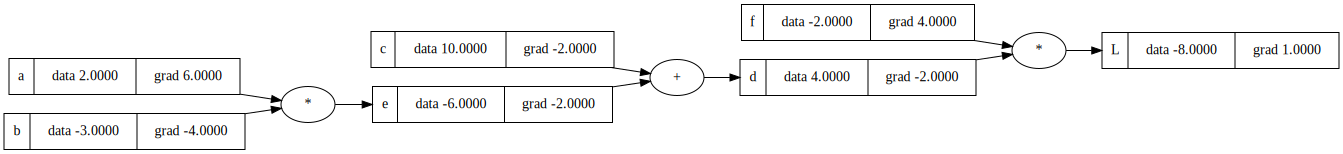

In [38]:
draw_dot(L)

In [39]:
def lol():
    # 不想污染全局的那些变量
    # 对哪个变量求导就对哪个变量在第二部分加 h
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = "d"
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    # var + h 
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    
    c.data += h 
    
    e = a*b; e.label = 'e'
    d = e + c; d.label = "d"
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data 

    print((L2 - L1)/h)

In [40]:
# 相当于是求L 对+h 的那个变量的求偏导数
lol()

-1.999999998503199


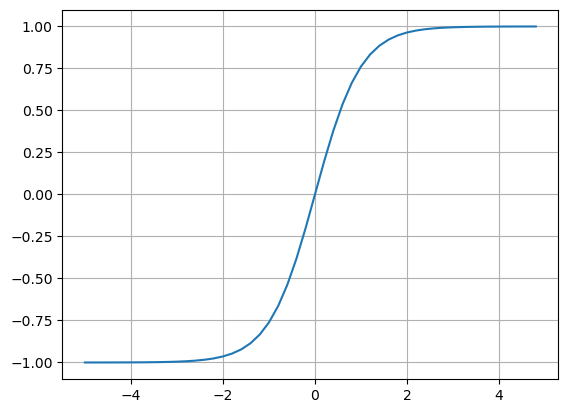

In [45]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()
plt.show()

In [ ]:
# inputs x1, x2 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label='n' 
# print(n) 

# output 
o = n.tanh(); o.label='o'

# draw_dot(o)

### 手动反向传播, 求梯度

In [48]:
# init 
o.grad = 1.0 

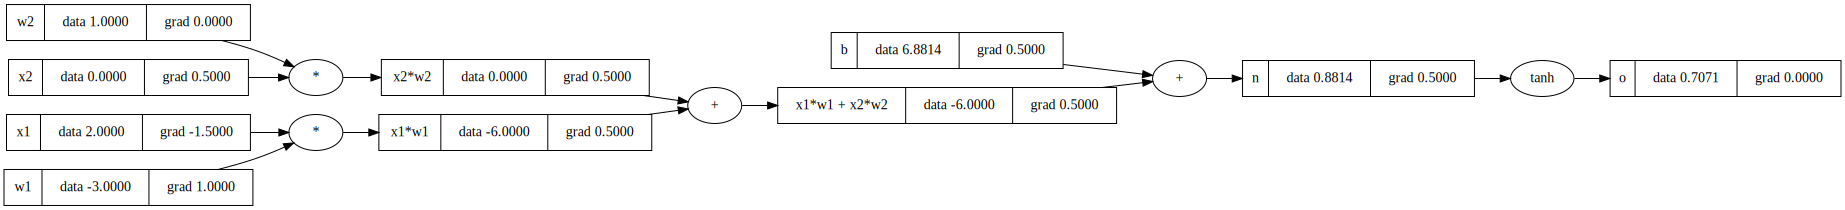

In [74]:
draw_dot(o)

In [50]:
# o = tanh(n)
# do / dn = 1 - tanh(n)**2 = 1 - o**2 

In [68]:
1 - o.data**2

0.4999999999999999

In [69]:
# so 
n.grad = 0.5

In [70]:
x1w1x2w2.grad = b.grad = n.grad

In [71]:
x1w1.grad = x2w2.grad = 0.5 

In [72]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad 

In [73]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

### 通过_backward属性, 这个属性是个函数. 来求梯度

In [98]:
# inputs x1, x2 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label='n' 
# print(n) 

# output 
o = n.tanh(); o.label='o'

In [99]:
print(o), type(o)

Value(data=0.7071067811865476)


(None, __main__.Value)

In [100]:
print(type(o).__name__)

Value


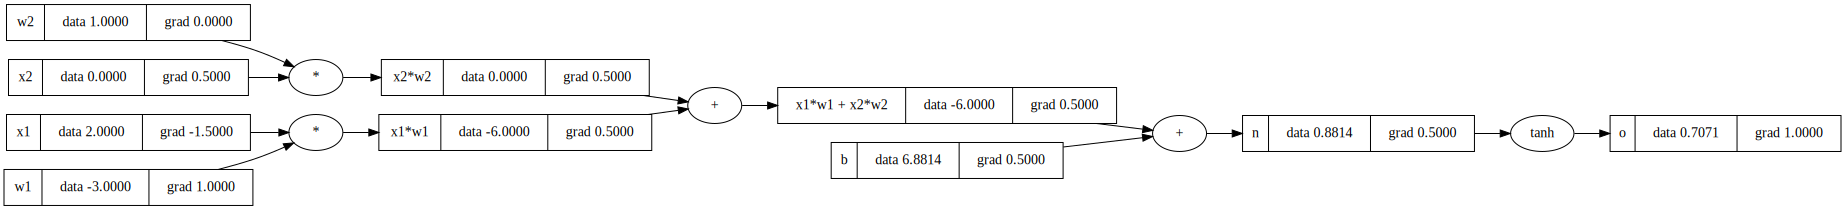

In [149]:
draw_dot(o)

In [142]:
o.grad = 1.0 

In [143]:
o._backward()

In [144]:
n._backward()

In [145]:
b._backward() # 因为b是叶结点, 所以他在Value里面初始化的时候为lambda:None, 是个空函数

In [146]:
x1w1x2w2._backward()

In [147]:
x1w1._backward()

In [148]:
x2w2._backward()

In [ ]:
# 只有将自己的所有子结点处理完了之后, 才会将自己加入拓扑排序中

In [117]:
topo = [] 

visited = set()

def build_topo(v): 
    if v not in visited:
        visited.add(v)
        for child in v._prev: 
            build_topo(child)
        topo.append(v)

In [118]:
build_topo(o)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [119]:
for value in topo:
    print(value.label)

w1
x1
x1*w1
x2
w2
x2*w2
x1*w1 + x2*w2
b
n
o


In [150]:
# inputs x1, x2 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label='n' 
# print(n) 

# output 
o = n.tanh(); o.label='o'

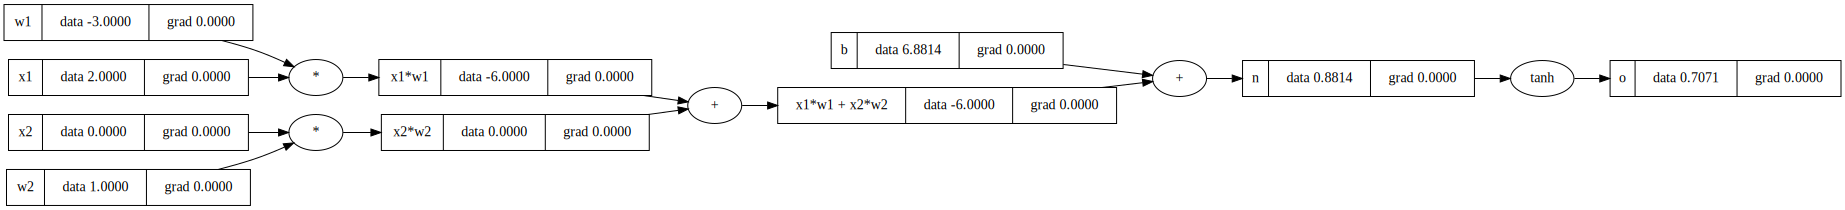

In [151]:
draw_dot(o)

In [138]:
topo = [] 

visited = set()

def build_topo(v): 
    if v not in visited:
        visited.add(v)
        for child in v._prev: 
            build_topo(child)
        topo.append(v)

In [152]:
# 基于这个topo的逆序 ,我们进行反向传播求梯度 
# ************* 从而更新我们的Value的backward函数 *************
build_topo(o)

o.grad = 1
for node in reversed(topo): 
    # print(node)
    node._backward()

Value(data=0.7071067811865476)
Value(data=0.8813735870195432)
Value(data=6.881373587019543)
Value(data=-6.0)
Value(data=0.0)
Value(data=1.0)
Value(data=0.0)
Value(data=-6.0)
Value(data=2.0)
Value(data=-3.0)


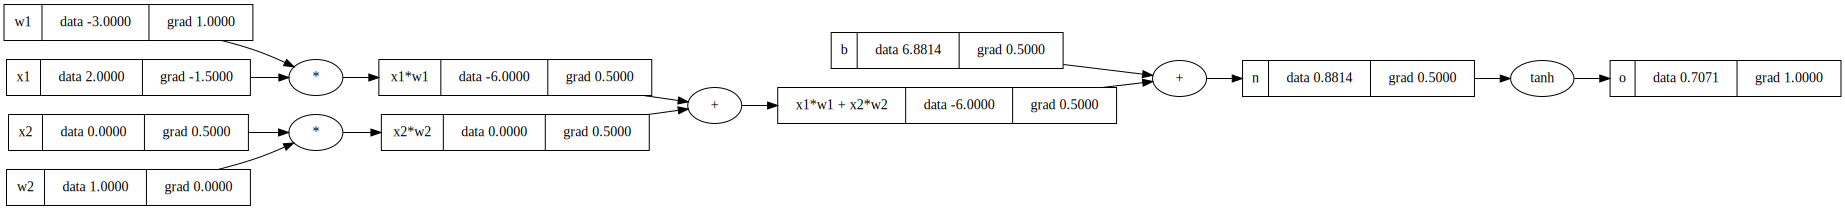

In [153]:
draw_dot(o)

In [155]:
# inputs x1, x2 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2 
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label='n' 
# print(n) 

# output 
o = n.tanh(); o.label='o'

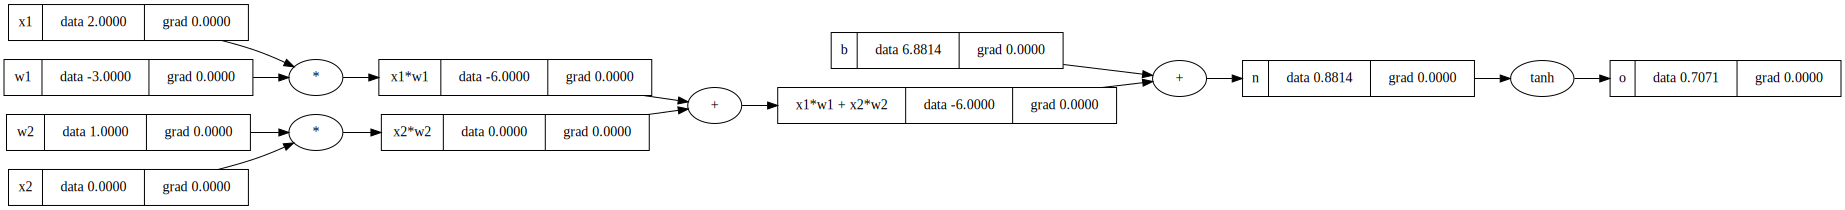

In [156]:
draw_dot(o)

In [157]:
o.backward()

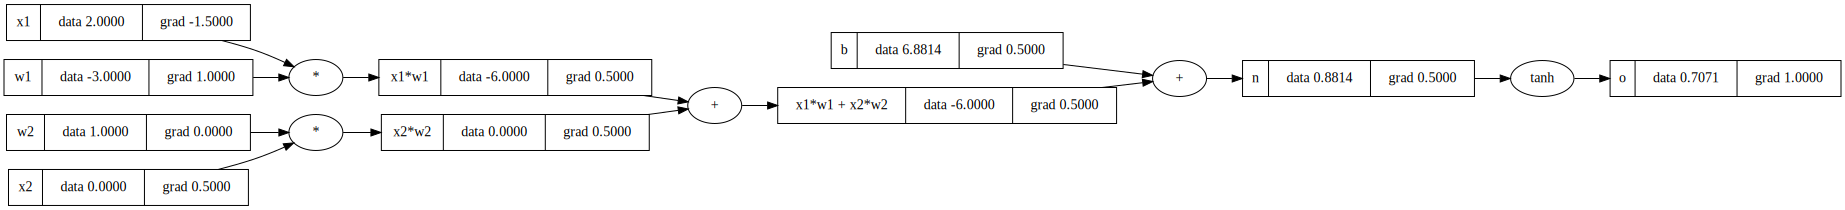

In [158]:
draw_dot(o)

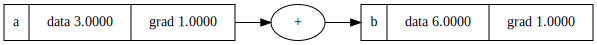

In [159]:
# bug--overwrite
# 在每个_backward 函数里面使用 = 而不是 +=的时候, 所产生的
# 因为梯度这个东西应该累计才对
a = Value(3.0, label='a')
# 这里创建b的是两个节点是self 和 other, 但是其实这两个都是a
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

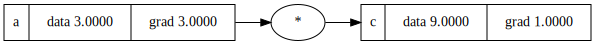

In [161]:
# bug2
a = Value(3.0, label='a') 
# b = Value(2.0, label='b')
c = a * a; c.label= 'c'
c.backward()
draw_dot(c)

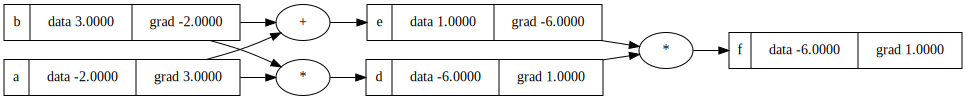

In [163]:
# bug3--尤其是这个更明显
a = Value(-2.0, label='a') 
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e' 
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)